Raw columns: ['SNO', 'MRD No.', 'D.O.A', 'D.O.D', 'AGE', 'GENDER', 'RURAL', 'TYPE OF ADMISSION-EMERGENCY/OPD', 'month year', 'DURATION OF STAY', 'duration of intensive unit stay', 'OUTCOME', 'SMOKING ', 'ALCOHOL', 'DM', 'HTN', 'CAD', 'PRIOR CMP', 'CKD', 'HB', 'TLC', 'PLATELETS', 'GLUCOSE', 'UREA', 'CREATININE', 'BNP', 'RAISED CARDIAC ENZYMES', 'EF', 'SEVERE ANAEMIA', 'ANAEMIA', 'STABLE ANGINA', 'ACS', 'STEMI', 'ATYPICAL CHEST PAIN', 'HEART FAILURE', 'HFREF', 'HFNEF', 'VALVULAR', 'CHB', 'SSS', 'AKI', 'CVA INFRACT', 'CVA BLEED', 'AF', 'VT', 'PSVT', 'CONGENITAL', 'UTI', 'NEURO CARDIOGENIC SYNCOPE', 'ORTHOSTATIC', 'INFECTIVE ENDOCARDITIS', 'DVT', 'CARDIOGENIC SHOCK', 'SHOCK', 'PULMONARY EMBOLISM', 'CHEST INFECTION']
Daily series built:  (1064, 4)
            admissions  temperature   rainfall  is_holiday
date                                                      
2017-01-04           1    20.550043  28.624892           0
2017-01-05           0    20.687249  28.281878           0
2017-01-06 

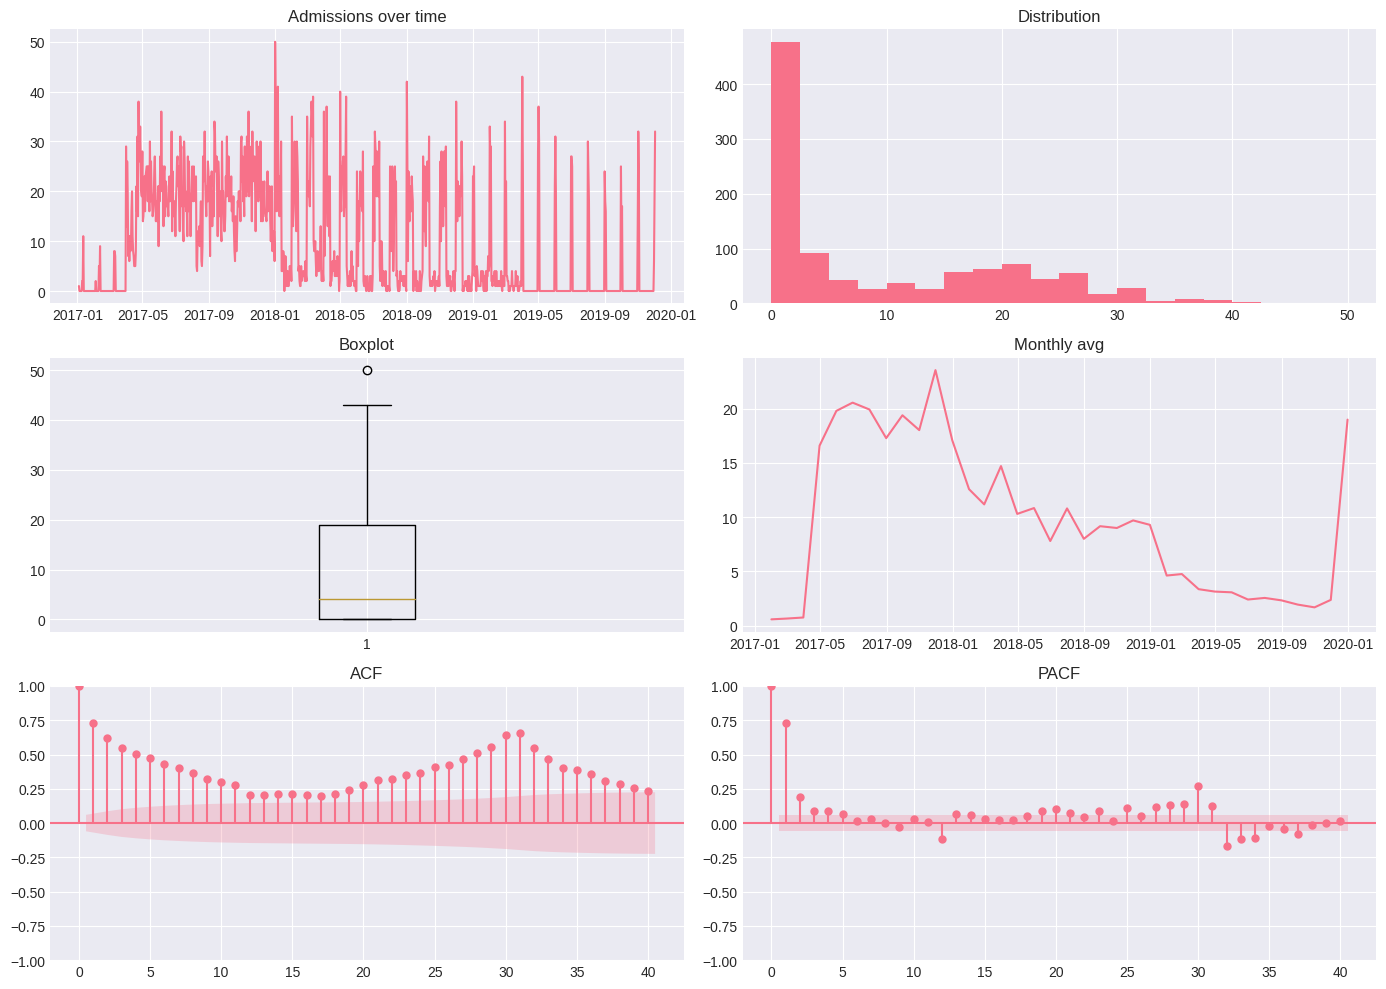

Train rows: 851 | Test rows: 213

Random Forest feature importance:
         feature  importance
0         lag_1    0.634766
8      rainfall    0.057334
7   temperature    0.056902
1         lag_2    0.038574
2         lag_3    0.037446
11        month    0.030663
5         lag_6    0.029675
4         lag_5    0.028771
10          dow    0.028563
3         lag_4    0.026342
6         lag_7    0.026308
9    is_holiday    0.004656

Model metrics:
                    MAE     RMSE          MAPE
Moving Average  13.164   13.329  5.509434e+18
Holt-Winters    15.046   15.368  6.430786e+18
ARIMA           12.377   12.520  5.121135e+18
SARIMA          13.995   14.249  5.909575e+18
SARIMAX         92.089  108.590  3.634067e+19
Random Forest    6.780    7.604  2.670157e+18


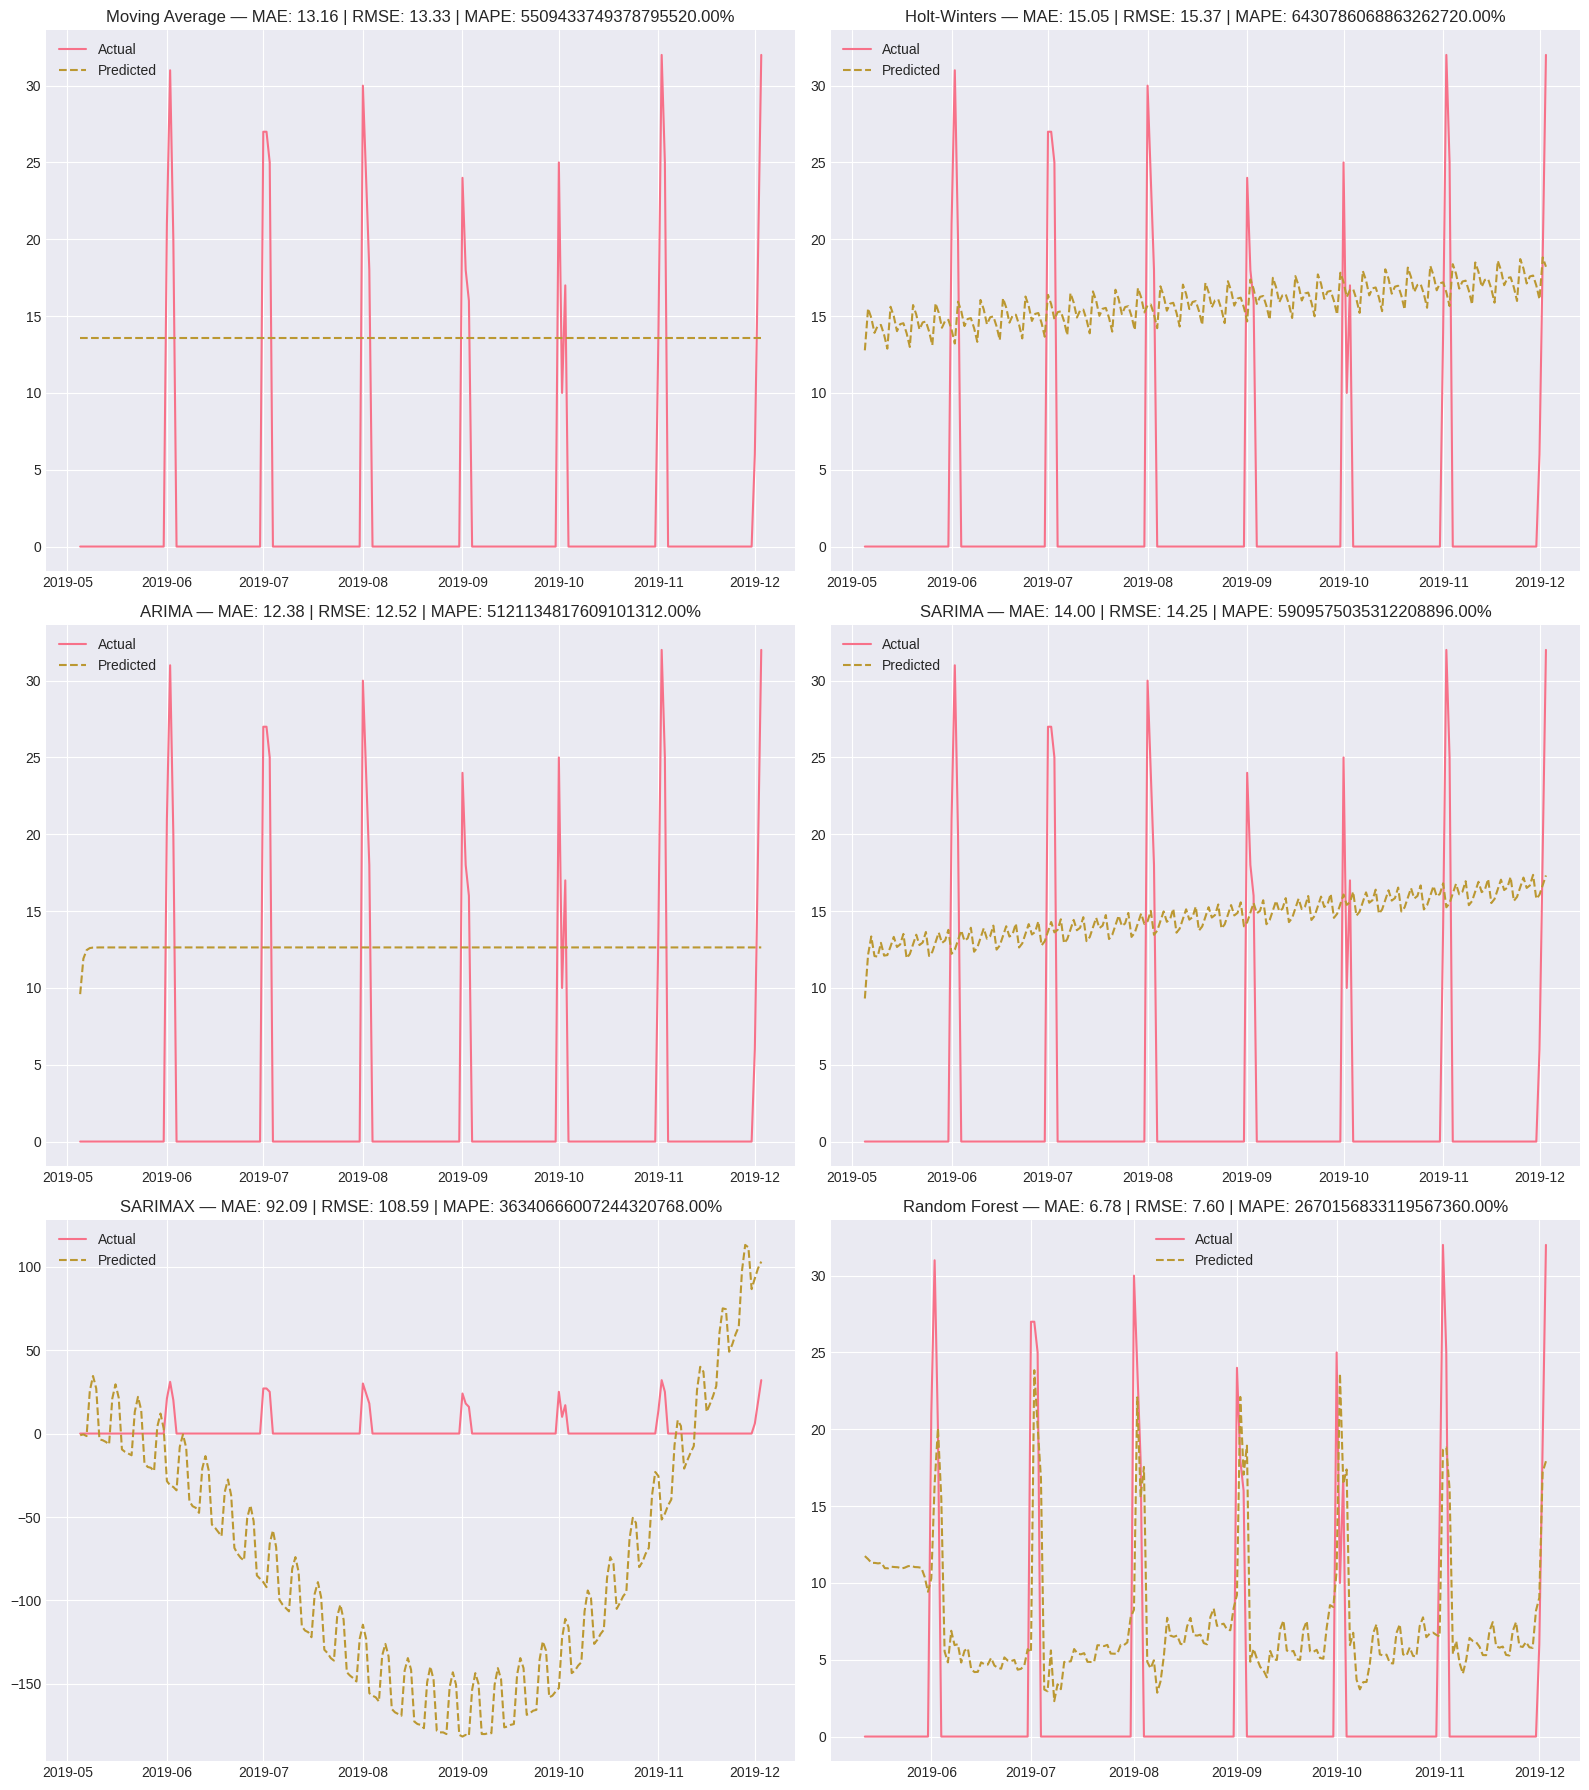


Done. Outputs saved: admissiondata_daily.csv, model comparison CSVs, and plots.


In [28]:
# Hospital Admissions Forecasting (uses 'D.O.A' as admission date)
# This script reads the raw hospital file and converts it to a daily admissions time series.
# Then it runs multiple forecasting models (no LSTM) and saves plots + metrics.

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# ---------------------------
# LOAD RAW CSV and build daily admissions
# ---------------------------
csv_path = '/kaggle/input/hospital-admissions-data/HDHI Admission data.csv'
if not os.path.exists(csv_path):
    csv_path = '/mnt/data/HDHI Admission data.csv'
if not os.path.exists(csv_path):
    csv_path = 'HDHI Admission data.csv'  # local fallback

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found. Update csv_path to correct location. Checked: {csv_path}")

# Read raw CSV
raw = pd.read_csv(csv_path)
print('Raw columns:', list(raw.columns))

# Use 'D.O.A' (Date of Admission) as the admission date column
if 'D.O.A' not in raw.columns:
    # try alternatives
    candidates = [c for c in raw.columns if c.lower().startswith('d.o') or 'admission' in c.lower()]
    if candidates:
        doa_col = candidates[0]
        print(f"Using detected column for admission date: {doa_col}")
    else:
        raise ValueError("No 'D.O.A' or admission date column found. Columns:\n" + str(list(raw.columns)))
else:
    doa_col = 'D.O.A'

# Parse D.O.A to datetime
raw[doa_col] = pd.to_datetime(raw[doa_col], errors='coerce', dayfirst=False)
# Drop rows without admission date
raw = raw.dropna(subset=[doa_col]).copy()
raw = raw.sort_values(doa_col).reset_index(drop=True)

# Create daily admissions counts (one row per admission)
raw['admission_date'] = raw[doa_col].dt.normalize()
daily = raw.groupby('admission_date').size().rename('admissions').to_frame()

# If there are days with zero admissions, create a continuous date index
date_idx = pd.date_range(daily.index.min(), daily.index.max(), freq='D')
daily = daily.reindex(date_idx, fill_value=0)
daily.index.name = 'date'

# Add simple exogenous proxies
daily['temperature'] = 20 + 8 * np.sin(2 * np.pi * (daily.index.dayofyear) / 365.25)
daily['rainfall'] = np.maximum(0, 30 + 20 * np.sin(2 * np.pi * (daily.index.dayofyear) / 365.25 + np.pi))
daily['is_holiday'] = (daily.index.dayofweek >= 5).astype(int)

print('Daily series built: ', daily.shape)
print(daily.head())

# Save cleaned daily CSV for future runs
daily.reset_index().rename(columns={'index':'date'}).to_csv('admissiondata_daily.csv', index=False)
print("Saved cleaned daily admissions to 'admissiondata_daily.csv'")

# ---------------------------
# EDA
# ---------------------------
print('\n=== EDA ===')
print(daily['admissions'].describe())

fig, axes = plt.subplots(3,2,figsize=(14,10))
axes[0,0].plot(daily.index, daily['admissions']); axes[0,0].set_title('Admissions over time')
axes[0,1].hist(daily['admissions'], bins=20); axes[0,1].set_title('Distribution')
axes[1,0].boxplot(daily['admissions']); axes[1,0].set_title('Boxplot')
axes[1,1].plot(daily['admissions'].resample('M').mean()); axes[1,1].set_title('Monthly avg')
plot_acf(daily['admissions'], lags=40, ax=axes[2,0]); axes[2,0].set_title('ACF')
plot_pacf(daily['admissions'], lags=40, ax=axes[2,1]); axes[2,1].set_title('PACF')
plt.tight_layout(); plt.savefig('eda_daily.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# Train/test split
# ---------------------------
train_size = int(len(daily) * 0.8)
train = daily.iloc[:train_size].copy()
test = daily.iloc[train_size:].copy()

y_train = train['admissions']
y_test = test['admissions']
exog_cols = ['temperature','rainfall','is_holiday']
exog_train = train[exog_cols]
exog_test = test[exog_cols]

print(f'Train rows: {len(train)} | Test rows: {len(test)}')

# ---------------------------
# Modeling (no LSTM)
# ---------------------------
predictions = {}

# Moving average baseline
window = 7
ma_val = y_train.rolling(window=window).mean().iloc[-1]
predictions['Moving Average'] = np.full(len(y_test), ma_val)

# Holt-Winters
try:
    hw = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=7).fit()
    predictions['Holt-Winters'] = hw.forecast(steps=len(y_test)).values
except Exception as e:
    print('Holt-Winters failed:', e)
    predictions['Holt-Winters'] = predictions['Moving Average']

# ARIMA
try:
    arima = ARIMA(y_train, order=(1,1,1)).fit()
    predictions['ARIMA'] = arima.forecast(steps=len(y_test)).values
except Exception as e:
    print('ARIMA failed:', e)
    predictions['ARIMA'] = predictions['Moving Average']

# SARIMA
try:
    sarima = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,7)).fit(disp=False)
    predictions['SARIMA'] = sarima.forecast(steps=len(y_test)).values
except Exception as e:
    print('SARIMA failed:', e)
    predictions['SARIMA'] = predictions.get('ARIMA', predictions['Moving Average'])

# SARIMAX with exogenous
try:
    sarimax = SARIMAX(y_train, exog=exog_train, order=(1,1,1), seasonal_order=(1,1,1,7)).fit(disp=False)
    predictions['SARIMAX'] = sarimax.forecast(steps=len(y_test), exog=exog_test).values
except Exception as e:
    print('SARIMAX failed:', e)
    predictions['SARIMAX'] = predictions.get('SARIMA', predictions['Moving Average'])

# Random Forest with lag features
def create_lags(df_, lags=7):
    X = pd.DataFrame(index=df_.index)
    for l in range(1,lags+1):
        X[f'lag_{l}'] = df_['admissions'].shift(l)
    for c in exog_cols:
        X[c] = df_[c]
    X['dow'] = df_.index.dayofweek
    X['month'] = df_.index.month
    return X.dropna()

train_feats = create_lags(train, lags=7)
combined = pd.concat([train.tail(7), test])
test_feats = create_lags(combined, lags=7).iloc[7:]

X_train = train_feats
y_train_rf = train.loc[train_feats.index,'admissions']
X_test = test_feats
y_test_rf = test.loc[test_feats.index,'admissions']

try:
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train_rf)
    predictions['Random Forest'] = rf.predict(X_test)
    fi = pd.DataFrame({'feature':X_train.columns,'importance':rf.feature_importances_}).sort_values('importance',ascending=False)
    print('\nRandom Forest feature importance:\n', fi)
except Exception as e:
    print('Random Forest failed:', e)
    predictions['Random Forest'] = np.full(len(test)-7, y_train.iloc[-7:].mean())

# ---------------------------
# Evaluation
# ---------------------------

def calc_metrics(y_true,y_pred):
    mae = mean_absolute_error(y_true,y_pred)
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    mape = mean_absolute_percentage_error(y_true,y_pred)*100
    return {'MAE':mae,'RMSE':rmse,'MAPE':mape}

metrics = {}
for name,pred in predictions.items():
    if name=='Random Forest':
        y_true = y_test_rf.values
    else:
        y_true = y_test.values
    pred = np.array(pred)
    minlen = min(len(y_true),len(pred))
    metrics[name] = calc_metrics(y_true[:minlen], pred[:minlen])

metrics_df = pd.DataFrame(metrics).T.round(3)
print('\nModel metrics:\n', metrics_df)
metrics_df.to_csv('model_comparison_daily_metrics.csv')

# ---------------------------
# Plot actual vs predicted
# ---------------------------
model_items = list(predictions.items())
rows = int(np.ceil(len(model_items)/2))
fig, axes = plt.subplots(rows,2,figsize=(16,6*rows))
axes = axes.flatten()
for i,(name,pred) in enumerate(model_items):
    ax = axes[i]
    try:
        if name=='Random Forest':
            dates = test.loc[test_feats.index].index
            actual = y_test_rf.values
        else:
            dates = test.index
            actual = y_test.values
        pred = np.array(pred)
        minlen = min(len(dates),len(pred),len(actual))
        ax.plot(dates[:minlen], actual[:minlen], label='Actual')
        ax.plot(dates[:minlen], pred[:minlen], linestyle='--', label='Predicted')
        m = metrics.get(name, {})
        ax.set_title(f"{name} — MAE: {m.get('MAE',np.nan):.2f} | RMSE: {m.get('RMSE',np.nan):.2f} | MAPE: {m.get('MAPE',np.nan):.2f}%")
        ax.legend(); ax.grid(True)
    except Exception as e:
        ax.text(0.5,0.5,f'Plot failed: {e}',ha='center'); ax.set_axis_off()
for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout(); plt.savefig('daily_models_comparison.png',dpi=300,bbox_inches='tight')
plt.show()

print('\nDone. Outputs saved: admissiondata_daily.csv, model comparison CSVs, and plots.')